# ONLY CIFAR

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import logging
from dataclasses import dataclass
from scipy.stats import linregress


# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Check for MPS (Metal Performance Shaders) backend
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
logging.info(f"Using device: {device}")

# Fixing seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configuration class
@dataclass
class Config:
    dataset_name: str = "CIFAR10"
    input_dim: int = None
    hidden_dim: int = 128
    output_dim: int = 10
    batch_size: int = 64
    learning_rate: float = 0.01
    num_epochs: int = 20
    weight_decay: float = 1e-4

# Compute alignment metrics (Pearson Correlation)
def compute_alignment(matrix1, matrix2):
    d = matrix1.shape[0]
    sum_product = torch.sum(matrix1 * matrix2)
    sum_matrix1 = torch.sum(matrix1)
    sum_matrix2 = torch.sum(matrix2)
    pearson_corr = (sum_product / (d**2)) - ((sum_matrix1 * sum_matrix2) / (d**4))
    normalization_factor = torch.norm(matrix1, p='fro') * torch.norm(matrix2, p='fro')
    return pearson_corr.item() / normalization_factor.item()

# Compute power-law exponents
def compute_power_law_exponent(eigenvalues):
    indices = np.arange(1, len(eigenvalues) + 1)
    slope, _, _, _, _ = linregress(np.log(indices), np.log(eigenvalues))
    return slope

# Metrics tracker class
class MetricsTracker:
    def __init__(self):
        self.alignments = []
        self.eigenvalue_spectra = []
        self.rank_history = []
        self.gradient_noise_scales = []
    
    def update(self, alignment, eigenvalues, rank, noise_scale):
        self.alignments.append(alignment)
        self.eigenvalue_spectra.append(eigenvalues)
        self.rank_history.append(rank)
        self.gradient_noise_scales.append(noise_scale)
    
    def plot_all(self):
        self.plot_alignment()
        self.plot_eigenvalues()
        self.plot_rank_history()
        self.plot_gradient_noise_scales()
    
    def plot_alignment(self):
        plt.plot(self.alignments)
        plt.title("Alignment Metrics Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Alignment")
        plt.show()
    
    def plot_eigenvalues(self):
        for epoch, eigvals in enumerate(self.eigenvalue_spectra):
            if epoch % 10 == 0:
                plt.plot(eigvals, label=f"Epoch {epoch}")
        plt.title("Eigenvalue Spectra Over Epochs")
        plt.xlabel("Eigenvalue Index")
        plt.ylabel("Eigenvalue")
        plt.legend()
        plt.show()
    
    def plot_rank_history(self):
        plt.plot(self.rank_history)
        plt.title("Rank of Representations Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Rank")
        plt.show()
    
    def plot_gradient_noise_scales(self):
        plt.plot(self.gradient_noise_scales)
        plt.title("Gradient Noise Scale Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Noise Scale")
        plt.show()

# Training class
class Trainer:
    def __init__(self, model, dataloader, optimizer, criterion, metrics_tracker):
        self.model = model
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.criterion = criterion
        self.metrics_tracker = metrics_tracker
    
    def train_epoch(self, epoch, num_epochs):
        logging.info(f"Epoch {epoch+1}/{num_epochs}")
        for X, y in self.dataloader:
            X, y = X.to(device), y.to(device)
            self.optimizer.zero_grad()
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            loss.backward()
            self.optimizer.step()
        logging.info(f"Loss after epoch {epoch+1}: {loss.item()}")
    
    def compute_metrics(self, X):
        with torch.no_grad():
            for layer in self.model.children():
                if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
                    weights = layer.weight
                    gradients = layer.weight.grad
                    
                    # Flatten input data
                    flattened_X = X.view(X.size(0), -1) if len(X.size()) > 2 else X
                    covariance_h = torch.cov(flattened_X.cpu().T)
                    
                    # Flatten gradients
                    flattened_gradients = gradients.view(gradients.size(0), -1) if len(gradients.shape) > 2 else gradients
                    covariance_g = torch.cov(flattened_gradients.cpu().T)
                    
                    # Ensure matrices have same dimensions
                    min_dim = min(covariance_h.size(0), covariance_g.size(0))
                    covariance_h = covariance_h[:min_dim, :min_dim]
                    covariance_g = covariance_g[:min_dim, :min_dim]
                    
                    # Compute metrics
                    alignment = compute_alignment(covariance_h, covariance_g)
                    eigenvalues_h = torch.linalg.eigvalsh(covariance_h).numpy()
                    rank = torch.linalg.matrix_rank(covariance_h).item()
                    grad_norm = torch.norm(gradients)
                    noise_scale = grad_norm / (torch.norm(gradients, dim=1).mean())
                    
                    # Update metrics
                    self.metrics_tracker.update(alignment, eigenvalues_h, rank, noise_scale.item())

# Define a ResNet-like CNN
class SimpleResNet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleResNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Corrected input size
        self.fc2 = nn.Linear(256, num_classes)
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.nn.functional.avg_pool2d(x, 2)  # Output shape: (batch_size, 128, 16, 16)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 128 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define dataset loader
def load_dataset(dataset_name="CIFAR10", batch_size=32):
    if dataset_name == "CIFAR10":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
        test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset. Currently supported: 'CIFAR10'.")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

2025-02-11 17:16:27,438 - INFO - Using device: mps


2025-02-11 17:16:29,528 - INFO - Epoch 1/20
2025-02-11 17:16:43,385 - INFO - Loss after epoch 1: 0.7402336597442627
2025-02-11 17:16:51,933 - INFO - Epoch 2/20
2025-02-11 17:17:05,585 - INFO - Loss after epoch 2: 0.8273959159851074
2025-02-11 17:17:13,500 - INFO - Epoch 3/20
2025-02-11 17:17:27,125 - INFO - Loss after epoch 3: 0.9478760957717896
2025-02-11 17:17:34,336 - INFO - Epoch 4/20
2025-02-11 17:17:47,751 - INFO - Loss after epoch 4: 0.8997867107391357
2025-02-11 17:17:55,169 - INFO - Epoch 5/20
2025-02-11 17:18:08,595 - INFO - Loss after epoch 5: 1.1186659336090088
2025-02-11 17:18:16,100 - INFO - Epoch 6/20
2025-02-11 17:18:29,861 - INFO - Loss after epoch 6: 0.37274107336997986
2025-02-11 17:18:37,722 - INFO - Epoch 7/20
2025-02-11 17:18:51,680 - INFO - Loss after epoch 7: 0.44421830773353577
2025-02-11 17:18:59,409 - INFO - Epoch 8/20
2025-02-11 17:19:13,467 - INFO - Loss after epoch 8: 0.3762885332107544
2025-02-11 17:19:20,745 - INFO - Epoch 9/20
2025-02-11 17:19:34,322 - 

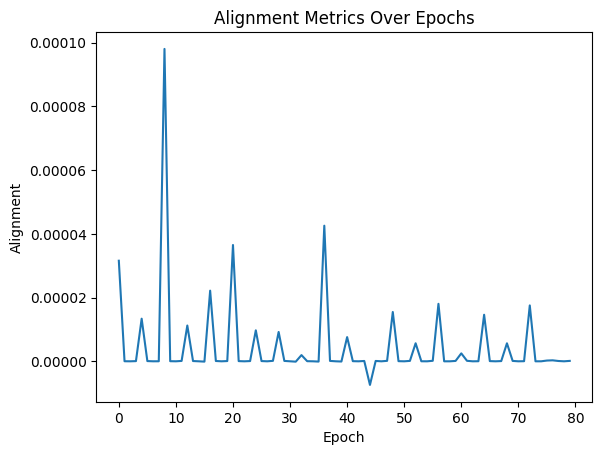

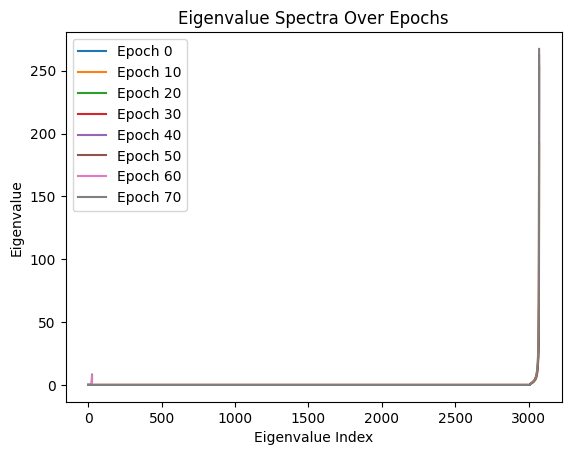

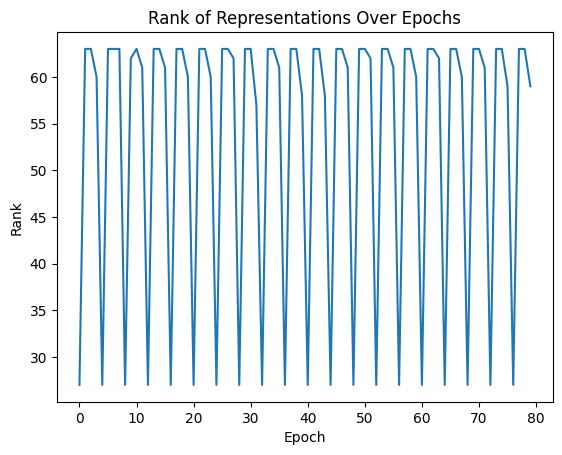

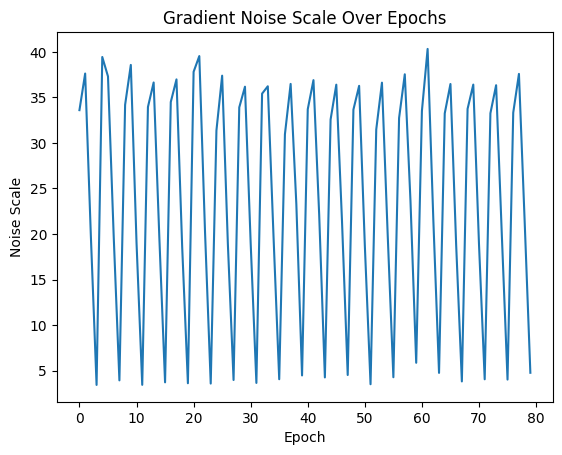

In [2]:
if __name__ == "__main__":
    # Initialize components
    config = Config()
    metrics_tracker = MetricsTracker()
    
    # Load dataset and model
    train_loader, test_loader = load_dataset(config.dataset_name, batch_size=config.batch_size)
    model = SimpleResNet(input_channels=3, num_classes=config.output_dim).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    
    # Initialize trainer
    trainer = Trainer(model, train_loader, optimizer, criterion, metrics_tracker)
    
    # Training loop
    for epoch in range(config.num_epochs):
        trainer.train_epoch(epoch, config.num_epochs)
        # Compute metrics on first batch
        X, _ = next(iter(train_loader))
        trainer.compute_metrics(X)
    
    # Plot results
    metrics_tracker.plot_all()